# CNN_UTK_Model for AgeRange classification

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
plt.style.use('ggplot')

### Data preprocessing

In [2]:
df = pd.read_csv('./dataset/UTK_dataset.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [4]:
df.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [5]:
df.isna().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [6]:
df['pixels']=df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 133..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175...."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79...."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 202..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 210..."


In [7]:
len(df['age'].unique())

104

### Data analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

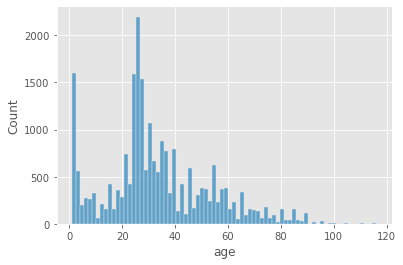

In [8]:
sns.histplot(data=df, x='age')

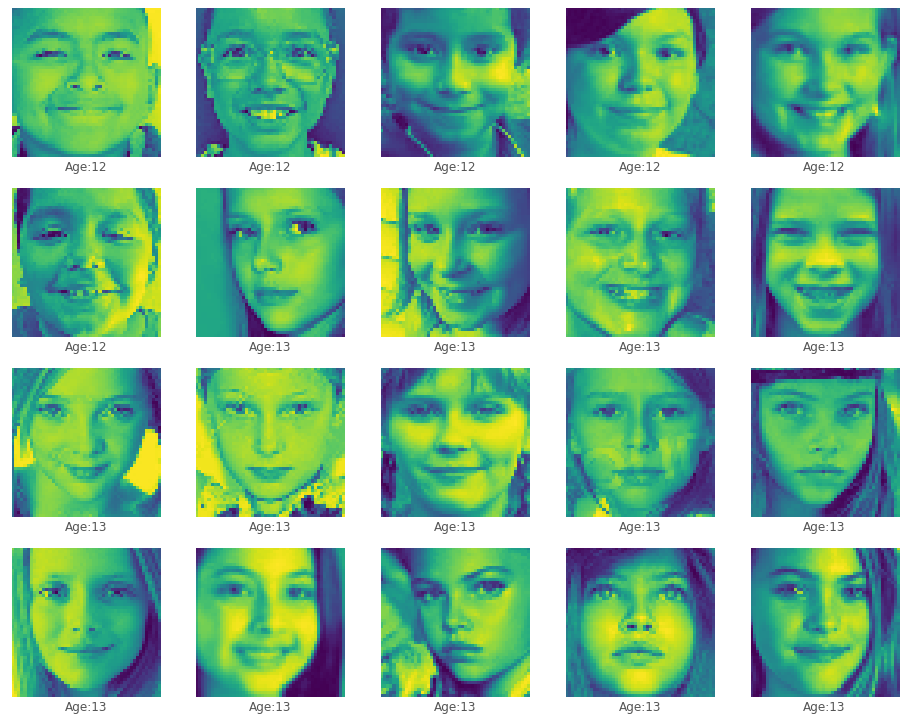

In [9]:
plt.figure(figsize=(16,16))
for i in range(1500,1520):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i]))
plt.show()

In [10]:
X = np.array(df['pixels'].tolist())
# taking range of 5
y = df['age'] // 5

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [12]:
X = X.reshape(X.shape[0],48,48,1)

In [13]:
X[:5].shape

(5, 48, 48, 1)

In [14]:
y[:5].shape

(5,)

In [15]:
y = to_categorical(y, num_classes=24)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Model creation

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [22]:
model = Sequential()

model.add(InputLayer(input_shape=(48, 48, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(24, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "mae"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                541728    
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
Total params: 542,840
Trainable params: 542,840
Non-trainable params: 0
_________________________________________________________________


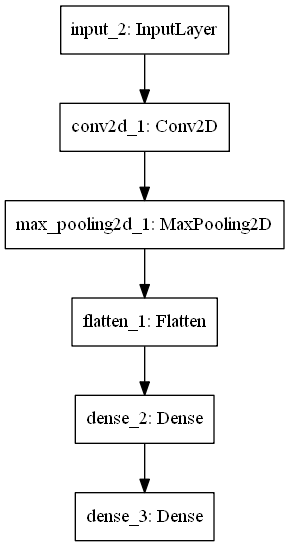

In [23]:
plot_model(model, to_file='models/cnn_utk_model_1_age-range-classification.png')

In [24]:
filepath = 'checkpoints/age_range_model1_classification_relu.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="min", verbose=1)

In [25]:
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
333/334 [============================>.] - ETA: 0s - loss: 2.4059 - accuracy: 0.2773 - mae: 0.0707
Epoch 00001: val_loss improved from inf to 2.13764, saving model to checkpoints\age_range_model1_classification_relu.epoch01-loss2.14.hdf5
334/334 [==============================] - 10s 29ms/step - loss: 2.4056 - accuracy: 0.2774 - mae: 0.0707 - val_loss: 2.1376 - val_accuracy: 0.3032 - val_mae: 0.0686
Epoch 2/20
332/334 [============================>.] - ETA: 0s - loss: 2.0378 - accuracy: 0.3200 - mae: 0.0656
Epoch 00002: val_loss improved from 2.13764 to 2.01569, saving model to checkpoints\age_range_model1_classification_relu.epoch02-loss2.02.hdf5
334/334 [==============================] - 10s 30ms/step - loss: 2.0378 - accuracy: 0.3202 - mae: 0.0656 - val_loss: 2.0157 - val_accuracy: 0.3075 - val_mae: 0.0653
Epoch 3/20
333/334 [============================>.] - ETA: 0s - loss: 1.9055 - accuracy: 0.3475 - mae: 0.0636
Epoch 00003: val_loss improved from 2.01569 to 1.90206, sa

<AxesSubplot:>

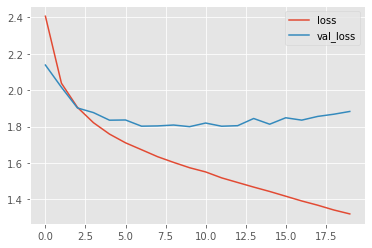

In [26]:
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot()

In [27]:
from tensorflow.math import argmax

In [28]:
y_pred = argmax(model.predict(X), axis=1)

In [29]:
np.array(y_pred).sum() / len(y_pred)

5.8900653870491455

Text(0.5, 1.0, 'Predicted vs Original')

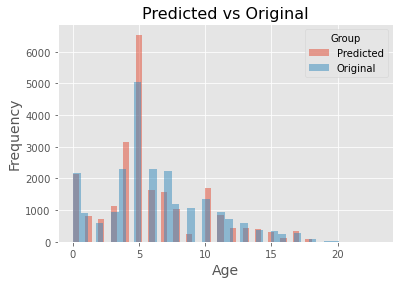

In [30]:
pd.Series((y_pred)).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series(argmax(y, axis = 1)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

In [31]:
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

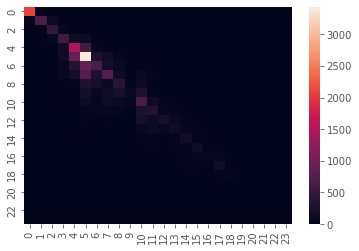

In [32]:
sns.heatmap(confusion_matrix(argmax(y, axis = 1), y_pred))

In [38]:
y_pred.numpy()

array([ 0,  0,  0, ..., 19, 18, 14], dtype=int64)

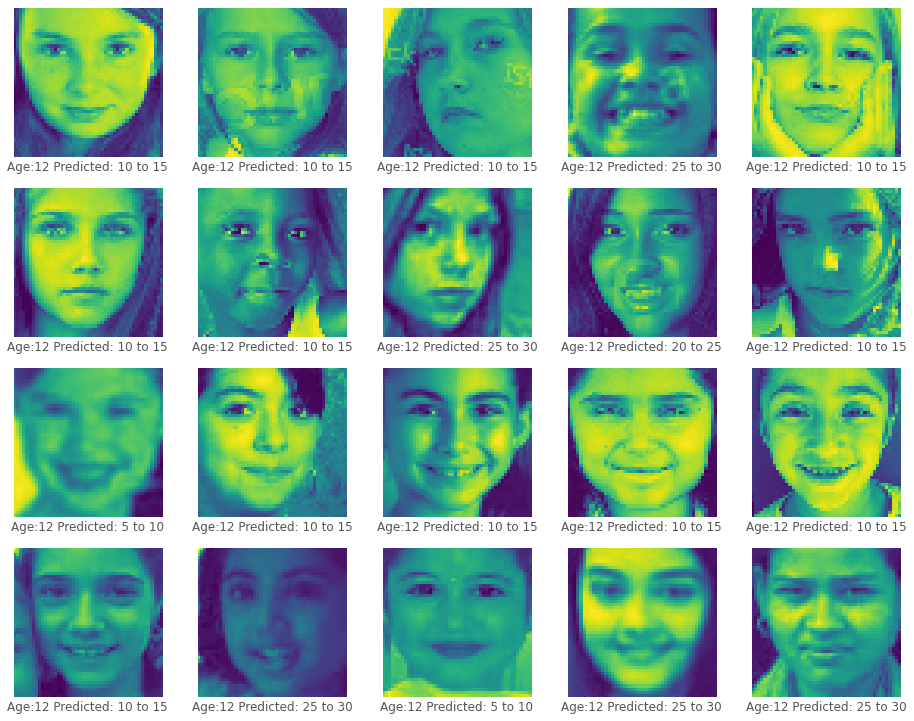

In [39]:
plt.figure(figsize=(16,16))
for i in range(1400,1420):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    pred_age = (5 * (y_pred.numpy()[i]))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i])+" Predicted: "+str(pred_age) + " to " + str(pred_age + 5))
plt.show()

### Predictions for best model

In [40]:
import os
path = os.getcwd() + r'\checkpoints\age_range_model1_classification_relu.epoch10-loss1.80.hdf5'

In [41]:
best_model = tf.keras.models.load_model(path)

In [42]:
y_pred_best = argmax(best_model.predict(X), axis=1)

Text(0.5, 1.0, 'Predicted vs Original')

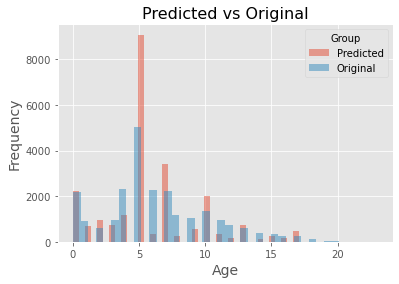

In [43]:
pd.Series((y_pred_best)).plot(kind='hist', bins=40, label='Predicted', alpha=0.5)
pd.Series(argmax(y, axis = 1)).plot(kind='hist', bins=40, label='Original', alpha=0.5)

plt.legend(title='Group')

plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.title('Predicted vs Original', fontsize=16)

<AxesSubplot:>

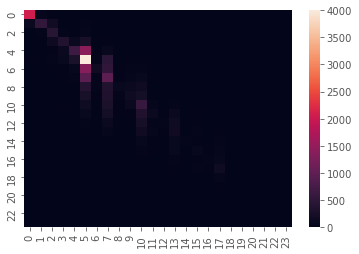

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
sns.heatmap(confusion_matrix(argmax(y, axis = 1), y_pred_best))

In [45]:
print(classification_report(argmax(y, axis = 1), y_pred_best))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2167
           1       0.77      0.59      0.67       895
           2       0.44      0.70      0.54       589
           3       0.50      0.38      0.43       942
           4       0.54      0.28      0.37      2310
           5       0.44      0.80      0.57      5034
           6       0.48      0.07      0.13      2290
           7       0.28      0.43      0.34      2246
           8       0.33      0.07      0.12      1181
           9       0.26      0.14      0.18      1064
          10       0.29      0.44      0.35      1345
          11       0.28      0.10      0.15       954
          12       0.32      0.06      0.11       730
          13       0.23      0.28      0.25       586
          14       0.37      0.12      0.18       373
          15       0.26      0.21      0.23       326
          16       0.23      0.17      0.20       237
          17       0.30    

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


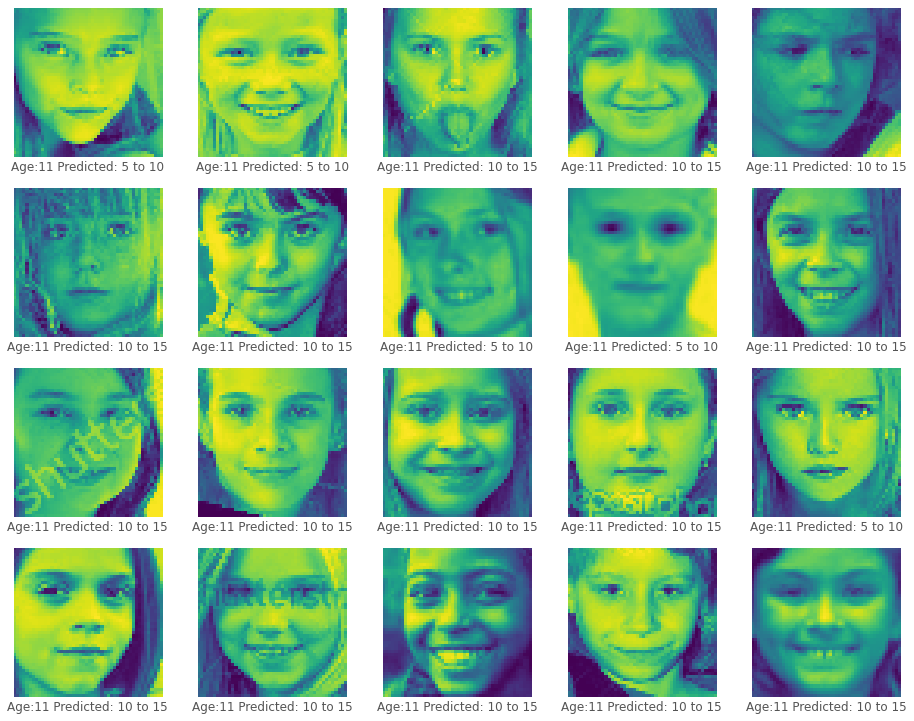

In [47]:
plt.figure(figsize=(16,16))
for i in range(1300,1320):
    plt.subplot(5,5,(i%25)+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df['pixels'].iloc[i].reshape(48,48))
    pred_age = (5 * (y_pred_best.numpy()[i]))
    plt.xlabel(
        "Age:"+str(df['age'].iloc[i])+" Predicted: "+str(pred_age) + " to " + str(pred_age + 5))
plt.show()